
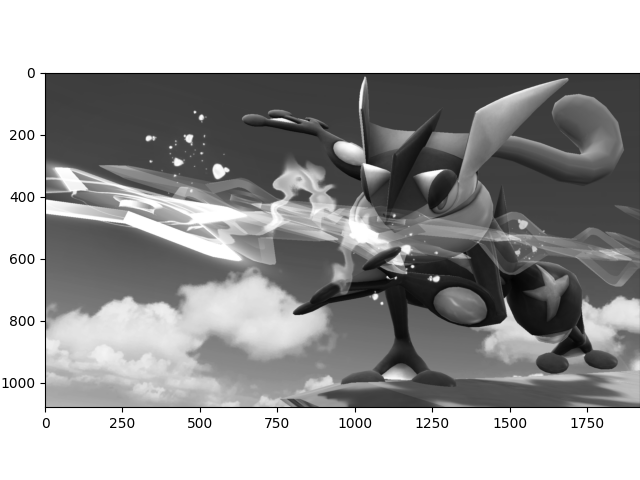

In [1]:
import torchOptics.optics as tt
import warnings 
import torch.nn as nn
import torch
from torchvision.utils import save_image
warnings.filterwarnings('ignore') ## ignore warnings
meta = {'wl' : (638e-9), 'dx':(6.3e-6, 6.3e-6)}
timg = tt.imread('dataset/pokemon.png', meta = meta, gray = True)
field = timg.clone()

tt.show(field)

In [2]:
class SignFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        output = (torch.sign(input)+1)/2
        output = output.type(torch.int32)
        output = output.type(torch.float32)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output * torch.ones_like(input)  # Replace with your custom gradient computation
        return grad_input

In [28]:
def get_psnr(img1, img2, min_value=0, max_value=1):
    """
    psnr 을 계산해준다.
    이미지가 [0., 255] 이면 min_value=0, max_valu=255 로 해주고,
    이미지가 [-1,1]의 범위에 있으면 min_value=-1, max_valu=1 로 설정 해준다.
    """
    mse = torch.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = max_value - min_value
    return 10 * torch.log10((PIXEL_MAX ** 2) / mse)

In [24]:
def complete_binary_optimize(image_num, z, epochs, lr_val):
    output = tt.Tensor(torch.rand(image_num, 1, field.size()[-2], field.size()[-1]), meta = meta)
    output = output.to('cuda')

    sign_function = SignFunction.apply
    
    amp = output.abs()
    ph = torch.angle(output)
    
    amp.requires_grad = True
    optimizer = torch.optim.Adam([amp], lr = lr_val)
    criterion = nn.MSELoss()
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        mean = torch.mean(amp-0.5, dim = 1, keepdim = True)
        binary = sign_function(mean)
        binary = binary.to('cuda:0')
        concat = binary * torch.exp(1j*ph)
    
        sim = tt.simulate(concat, z)
        sum_sim = torch.sum(sim, dim = 0) / image_num
        sum_sim = sum_sim.abs()**2
        
        loss = criterion(sum_sim, timg)
        loss.backward()
        optimizer.step()
        if epoch % (epochs//10) == 0:
            print(loss)
    continuos_ = output
    reconstructed_image = torch.sum(tt.simulate(binary * torch.exp(1j*ph), z), dim = 0) / image_num
    reconstructed_image = reconstructed_image.abs()**2
    return binary, reconstructed_image

In [12]:
binary, recon = complete_binary_optimize(2, 20e-3, 1000) #lr = 0.001

0.12302429974079132
0.08284930139780045
0.05498852953314781
0.03494664281606674
0.022280005738139153
0.01646289974451065
0.015115521848201752
0.0152127081528306
0.015542257577180862
0.015912871807813644


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


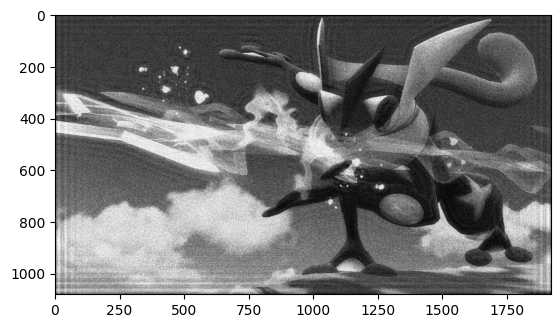

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [13]:
recon

In [14]:
get_psnr(timg, recon, 0.0, 1.1)

18.73690414428711

In [15]:
binary, recon = complete_binary_optimize(5, 20e-3, 1000)

0.10291030257940292
0.06956502050161362
0.04350363463163376
0.024691151455044746
0.013170070014894009
0.007431746926158667
0.005103221163153648
0.004282899666577578
0.003970211371779442
0.0038341237232089043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


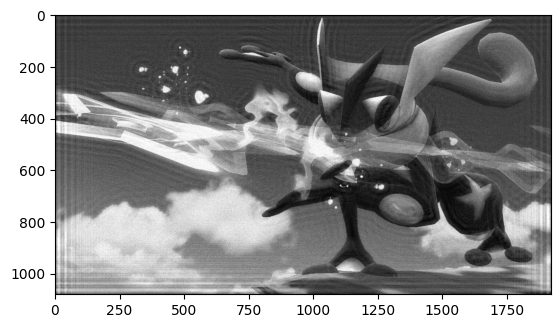

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [16]:
recon

In [17]:
get_psnr(timg, recon, 0.0, 1.1)

25.059593200683594

In [18]:
binary, recon = complete_binary_optimize(10, 20e-3, 1000)

0.09883395582437515
0.06889398396015167
0.044251032173633575
0.0259669478982687
0.014157219789922237
0.007669638376682997
0.004614077974110842
0.003306885017082095
0.0027241844218224287
0.002417749259620905


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


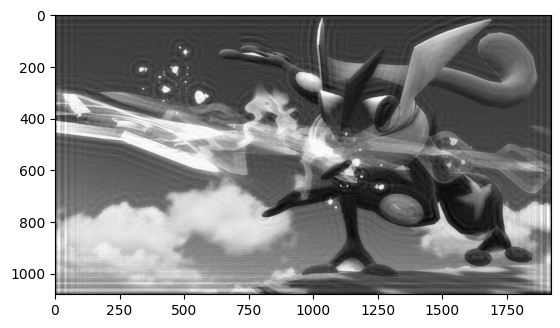

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [19]:
recon

In [20]:
get_psnr(timg, recon, 0.0, 1.1)

27.34134864807129

In [23]:
binary.size()

torch.Size([10, 1, 1080, 1920])

In [36]:
binary, recon = complete_binary_optimize(10, 20e-3, 1000, 0.01)

0.09876835346221924
0.00237724999897182
0.0017098704120144248
0.0015958771109580994
0.001548451604321599
0.0015185103984549642
0.0014974972000345588
0.0014839908108115196
0.0014713683631271124
0.0014632552629336715


In [37]:
get_psnr(timg, recon, 0, 1)

28.353994369506836

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


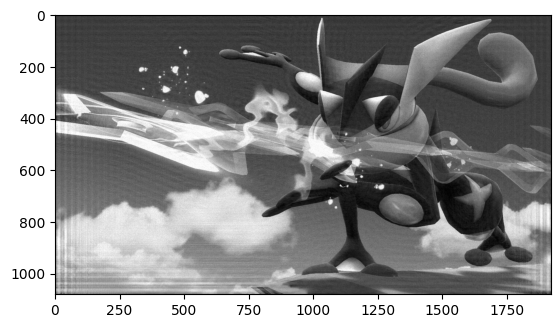

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [38]:
recon

In [31]:
binary, recon = complete_binary_optimize(10, 20e-3, 200, 0.01)
get_psnr(timg, recon)

0.09882903099060059
0.04372064396739006
0.013031446374952793
0.004556417930871248
0.003010879037901759
0.002375964308157563
0.0020776791498064995
0.0019175068009644747
0.0018181754276156425
0.0017526188166812062


27.67505645751953

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


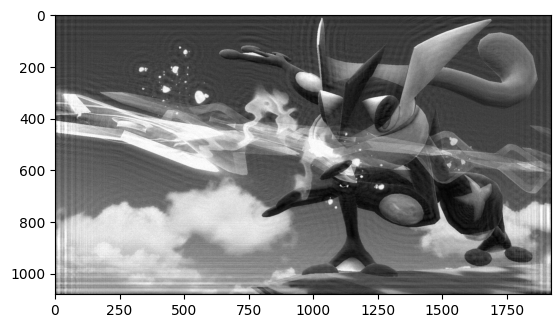

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [32]:
recon

In [29]:
binary, recon = complete_binary_optimize(10, 20e-3, 1000, 0.1)

0.0988081842660904
0.001758946105837822
0.0017366259125992656
0.0017344446387141943
0.0017369206761941314
0.0017338183242827654
0.0017350426642224193
0.0017340881749987602
0.0017378863412886858
0.0017370458226650953


In [30]:
get_psnr(timg, recon)

27.606292724609375

In [33]:
binary, recon = complete_binary_optimize(20, 20e-3, 200, 0.01)

0.09743382781744003
0.04917368292808533
0.017542261630296707
0.0053325253538787365
0.0030552344396710396
0.0023694115225225687
0.0020170805510133505
0.001801804406568408
0.0016560733783990145
0.0015511771198362112


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


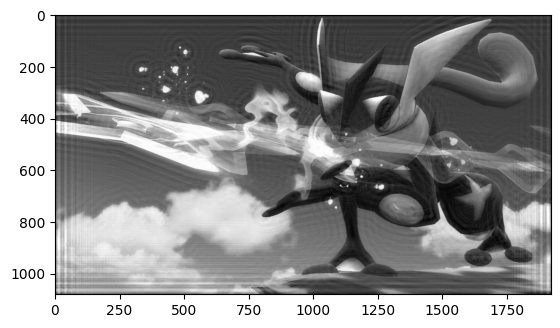

{'wl': 6.38e-07, 'dx': (6.3e-06, 6.3e-06)}

In [34]:
recon

In [35]:
get_psnr(timg, recon)

28.312625885009766